In [60]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

# R2 score
from sklearn.metrics import r2_score

# Analyse Outputs
import shap

# To split the data
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

# For further analysis
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests

import geopandas as gpd
import matplotlib as mpl
import matplotlib.colors as mcolors

import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.stattools import omni_normtest

# Define the custom color palette
colors = ["#4373c3", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]

In [61]:
# It is important that your model and all data are on the same device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Check that MPS is available - Added for MacOS
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

device

device(type='mps')

In [62]:
def get_data1(test_size=0.2, random_seed=42):
    '''
    returns:
    - train_data_input: Tensor[N_train_samples, C, F]
    - train_data_label: Tensor[N_train_samples, C, P]
    - test_data_input:  Tensor[N_test_samples,  C, F]
    - test_date_label:  Tensor[N_test_samples,  C, P]

    where 
     - N_train_samples = number of train/test samples
     - C = number of channels (here 1)
     - F = number of features
     - P = number of predicted features
    '''
    
    data    = pd.read_csv("../../ICPSR_IHDS-1/Simon_Personal_Aggregates/basic_plus1_features.csv")
    
    # Step 1: Replace ' ' and '' with -1
    data = data.replace([' ', ''], -1)
    # Step 2: Try to convert everything to numeric, forcing errors to NaN
    data = data.apply(pd.to_numeric, errors='coerce')
    # Step 3: Replace NaNs with -1
    data = data.fillna(-1)

    
    # 2. Drop rows with negative household_income
    data = data[ data['household_income'] >= 0 ]

    data_label = data['household_income']
    data_input = data.drop(['household_income', 'household_id', 'distid', 'distname', 'hhassets', 'highest_adult_ed'], axis=1)

    # Split data to get test and train set -> For generalization error prediction
    X_train, X_test, y_train, y_test = train_test_split(
        data_input, data_label,
        test_size=test_size,
        random_state=random_seed
    )
    
    # Convert to numpy arrays
    X_train_np = X_train.to_numpy().astype(np.long)
    X_test_np = X_test.to_numpy().astype(np.long)

    y_train_np = y_train.to_numpy().astype(np.float32)
    y_test_np = y_test.to_numpy().astype(np.float32)
    
    train_y_to = torch.tensor(y_train_np, dtype=torch.float32)
    test_y_to = torch.tensor(y_test_np, dtype=torch.float32)

    # Also prepare input_dict (for models expecting dict inputs)
    X_dict_train = {col: torch.tensor(X_train[col].values, dtype=torch.long) for col in X_train.columns}
    X_dict_test  = {col: torch.tensor(X_test[col].values, dtype=torch.long)  for col in X_test.columns}

    return X_dict_train, train_y_to, X_dict_test, test_y_to
    
    # return datainp_to, datalab_to, input_dict
    
    

X_train, y_train, X_test, y_test = get_data1()
# get_data1()

/var/folders/nk/x80qqs8j2d3d7n0h5xw1d8c00000gn/T/ipykernel_14160/3868177700.py:16: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data    = pd.read_csv("../../ICPSR_IHDS-1/Simon_Personal_Aggregates/basic_plus1_features.csv")


In [65]:
feature_names = [
    'stateid', 'highest_male_ed', 'highest_female_ed', 'literate_ad',
    'Nhh_salaried', 'Nhh_ag_wage', 'Nhh_nonag_wage', 'Nhh_fam_bus',
    'owns_car', 'owns_computer', 'npersons', 'nchild', 'nadults',
    'urban', 'metro', 'caste_rel'
]

print("Computed unique value counts for embedding features:")
for feat in feature_names:
    train_vals = X_train[feat].cpu().numpy()
    test_vals = X_test[feat].cpu().numpy()
    
    # Combine train and test to get true cardinality
    unique_vals = np.unique(np.concatenate([train_vals, test_vals]))
    print(f"{feat}: {len(unique_vals)} unique values -> {unique_vals.tolist()}")

Computed unique value counts for embedding features:
stateid: 33 unique values -> [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34]
highest_male_ed: 18 unique values -> [-4, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
highest_female_ed: 18 unique values -> [-4, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
literate_ad: 3 unique values -> [-1, 0, 1]
Nhh_salaried: 7 unique values -> [0, 1, 2, 3, 4, 5, 6]
Nhh_ag_wage: 10 unique values -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
Nhh_nonag_wage: 9 unique values -> [0, 1, 2, 3, 4, 5, 6, 7, 8]
Nhh_fam_bus: 8 unique values -> [0, 1, 2, 3, 4, 5, 6, 7]
owns_car: 3 unique values -> [-1, 0, 1]
owns_computer: 3 unique values -> [-1, 0, 1]
npersons: 33 unique values -> [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 38]
nchild: 17 unique values -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,

In [66]:
# Mapping of feature names to cardinalities
more_column_cardinalities = {
    'stateid': 33,
    'highest_male_ed': 18,
    'highest_female_ed': 18,
    'literate_ad': 3,
    'Nhh_salaried': 7,
    'Nhh_ag_wage': 10,
    'Nhh_nonag_wage': 9,
    'Nhh_fam_bus': 8,
    'owns_car': 3,
    'owns_computer': 3,
    'npersons': 33,
    'nchild': 17,
    'nadults': 17,
    'urban': 2,
    'metro': 7,
    'caste_rel': 8
}

# Heuristic for embedding dimension: half of unique categories, capped at 50
def get_embedding_dim(n_unique):
    return min(50, max(1, n_unique // 2))

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Embeddings for all categorical features
        self.embeddings = nn.ModuleDict({
            name: nn.Embedding(n_unique, get_embedding_dim(n_unique))
            for name, n_unique in more_column_cardinalities.items()
        })
        # Sum of all embedding dims
        total_embed_dim = sum(
            get_embedding_dim(n_unique)
            for n_unique in more_column_cardinalities.values()
        )
        
        # Fully connected
        self.fc = nn.Sequential(
            nn.Linear(total_embed_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1)
        )

    def forward(self, x_dict):
        # Embed each categorical feature
        embeds = [
            self.embeddings[name](x_dict[name])
            for name in more_column_cardinalities.keys()
        ]
        # Concatenate embeddings into a single vector
        x_embed = torch.cat(embeds, dim=1)  # [batch, total_embed_dim]
        # Pass through FC head
        output = self.fc(x_embed)           # [batch, 1]
        return output.squeeze(1)           # [batch]


In [52]:
%load_ext tensorboard
# %reload_ext tensorboard
# !rm -rf ./runs/
%tensorboard --logdir=runs --port=6006

'''
to kill process
pgrep -f tensorboard
kill -9 pid1 pid2 ...

Income
• Mean: 59659.41
• Minimum: -108327.80
• Maximum: 6520261.00
• Standard Deviation: 94614.89
'''

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'\nto kill process\npgrep -f tensorboard\nkill -9 pid1 pid2 ...\n\nIncome\n• Mean: 59659.41\n• Minimum: -108327.80\n• Maximum: 6520261.00\n• Standard Deviation: 94614.89\n'

def train_model(input_dict_train, y_train, input_dict_test, y_test, n_epochs=30):
    writer = SummaryWriter()
    
    # --- 1. Initialize model ---
    model = Model()
    model.train()
    model.to(device)

    # --- 2. Set up training elements ---
    criterion = torch.nn.MSELoss()  # For regression
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    batch_size = 64 # Small for CPU ussage and faster convergence
    # batch_size = 100000 # Large for GPU ussage

    # --- 3. Prepare training Dataset and DataLoader ---
    input_features_train = torch.cat(
        [input_dict_train[key].unsqueeze(1) for key in input_dict_train.keys()], dim=1
    )
    dataset_train = TensorDataset(input_features_train, y_train)
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

    # --- 4. Prepare test data ---
    input_features_test = torch.cat(
        [input_dict_test[key].unsqueeze(1) for key in input_dict_test.keys()], dim=1
    )
    dataset_test = TensorDataset(input_features_test, y_test)
    test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    # --- 5. Training loop ---
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False):
            # Split batch back into dict
            batch_input_dict = {}
            idx = 0
            for key in input_dict_train.keys():
                batch_input_dict[key] = batch_inputs[:, idx].to(device).long()
                idx += 1

            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()
            outputs = model(batch_input_dict)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        epoch_loss = epoch_loss / len(train_loader)

        # --- Evaluate on test set ---
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_inputs, batch_targets in tqdm(test_loader, desc=f"Testing model in Epoch {epoch}", leave=False):
                batch_input_dict = {}
                idx = 0
                for key in input_dict_test.keys():
                    batch_input_dict[key] = batch_inputs[:, idx].to(device).long()
                    idx += 1

                batch_targets = batch_targets.to(device)
                outputs = model(batch_input_dict)
                loss = criterion(outputs, batch_targets)
                test_loss += loss.item()

        test_loss = test_loss / len(test_loader)

        # --- Print training and test loss ---
        print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_loss:.4f} - Test Loss: {test_loss:.4f}')
        
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Loss/test", test_loss, epoch)

        # Save model every 10 epochs
        if (epoch % 10 == 9):
            print("Saving current state of the model")
            torch.save(model.state_dict(), 'NN_models/model_state_without_hhassets.pt')

    writer.close()
    model.eval()
    model.to(device)
    return model

def load_model(PATH="NN_models/model_state_without_hhassets.pt"):
    model = Model()

    model.load_state_dict(torch.load(PATH))
    model.eval()
    model.to(device)
    return model

# Either train or load model that is already trained
trained_model = train_model(X_train, y_train, X_test, y_test)
# path = "NN_models/model_state_without_hhassets.pt"
# trained_model = load_model(PATH=path)

In [101]:
def train_model(input_dict_train, y_train, input_dict_test, y_test, n_epochs=30,
                model_save_path='NN_models/best_model_state.pt', patience=5):
    writer = SummaryWriter()
    
    # --- 1. Initialize model ---
    # model = Model()
    model = load_model()
    # model.train() # Set to train mode at the beginning of each epoch's training phase
    model.to(device)

    # --- 2. Set up training elements ---
    criterion = torch.nn.MSELoss()  # For regression
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Lower LR, add weight_decay
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3) # Monitor test loss
    
    batch_size = 64 # Small for CPU usage and faster convergence
    # batch_size = 100000 # Large for GPU usage

    # --- 3. Prepare training Dataset and DataLoader ---
    # Assuming input_dict_train contains tensors already on the correct device or handle device transfer
    # It's generally better to put data to device inside the training loop if memory is a concern,
    # or create datasets with tensors already on the device if possible.
    # For simplicity, this structure keeps your original data loading approach.
    
    # Convert input dictionaries to feature tensors
    # Ensure keys are consistently ordered if relying on order for splitting later
    train_feature_keys = list(input_dict_train.keys())
    test_feature_keys = list(input_dict_test.keys())

    input_features_train_list = [input_dict_train[key].unsqueeze(1) for key in train_feature_keys]
    input_features_train = torch.cat(input_features_train_list, dim=1)
    
    dataset_train = TensorDataset(input_features_train, y_train)
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

    # --- 4. Prepare test data ---
    input_features_test_list = [input_dict_test[key].unsqueeze(1) for key in test_feature_keys]
    input_features_test = torch.cat(input_features_test_list, dim=1)
    
    dataset_test = TensorDataset(input_features_test, y_test)
    test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    # --- 5. Training loop with Early Stopping ---
    best_test_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        model.train() # Set model to training mode
        epoch_train_loss = 0.0
        
        for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{n_epochs}", leave=False):
            batch_input_dict = {}
            for idx, key in enumerate(train_feature_keys):
                batch_input_dict[key] = batch_inputs[:, idx].to(device).long() # Ensure .long() for embeddings

            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()
            outputs = model(batch_input_dict)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * batch_inputs.size(0) # Weighted by batch size

        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)

        # --- Evaluate on test set ---
        model.eval() # Set model to evaluation mode
        epoch_test_loss = 0.0
        with torch.no_grad():
            for batch_inputs, batch_targets in tqdm(test_loader, desc=f"Testing Epoch {epoch+1}/{n_epochs}", leave=False):
                batch_input_dict = {}
                for idx, key in enumerate(test_feature_keys):
                     batch_input_dict[key] = batch_inputs[:, idx].to(device).long() # Ensure .long() for embeddings
                
                batch_targets = batch_targets.to(device)
                outputs = model(batch_input_dict)
                loss = criterion(outputs, batch_targets)
                epoch_test_loss += loss.item() * batch_inputs.size(0) # Weighted by batch size
        
        epoch_test_loss = epoch_test_loss / len(test_loader.dataset)

        print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_train_loss:.4f} - Test Loss: {epoch_test_loss:.4f} - LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        writer.add_scalar("Loss/train", epoch_train_loss, epoch)
        writer.add_scalar("Loss/test", epoch_test_loss, epoch)
        writer.add_scalar("Learning_rate", optimizer.param_groups[0]['lr'], epoch)

        # --- Learning rate scheduler step ---
        scheduler.step(epoch_test_loss) # ReduceLROnPlateau needs the metric

        # --- Early stopping and model saving ---
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Test loss improved. Saving model to {model_save_path}')
        else:
            epochs_no_improve += 1
            print(f'Test loss did not improve for {epochs_no_improve} epoch(s).')

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs. Best test loss: {best_test_loss:.4f}')
            break
            
    writer.close()
    
    # Load the best model before returning
    print(f"Loading best model from {model_save_path} with test loss: {best_test_loss:.4f}")
    model.load_state_dict(torch.load(model_save_path))
    model.eval() # Ensure model is in eval mode after loading
    model.to(device) # Ensure model is on the correct device
    return model

# (Your load_model function can remain similar, but ensure it loads the path of the *best* model)
def load_model(PATH="NN_models/best_model_state.pt"): # Default to best model path
    model = Model() # Initialize your model structure
    model.load_state_dict(torch.load(PATH, map_location=device)) # Add map_location for flexibility
    model.eval()
    model.to(device)
    return model

# --- Example Usage (make sure X_train, y_train etc. are defined and are PyTorch tensors) ---
# Define device (do this once, globally or at the start of your script)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# Assuming X_train, y_train, X_test, y_test are already defined as dictionaries of tensors and target tensors
# e.g., y_train = torch.tensor(y_train_numpy_array, dtype=torch.float32).to(device)
#       X_train = {key: torch.tensor(value_numpy_array, dtype=torch.long).to(device) for key, value in X_train_dict_numpy.items()}

trained_model = train_model(X_train, y_train, X_test, y_test, n_epochs=150, patience=10) # Increased epochs, added patience
# path = "NN_models/best_model_state.pt"
# trained_model = load_model(PATH=path)

Epoch 1/150 - Train Loss: 7103942334.8260 - Test Loss: 6059125122.1336 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 2/150 - Train Loss: 7005999505.4402 - Test Loss: 6291425223.3274 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 3/150 - Train Loss: 6926865171.0717 - Test Loss: 6013412183.1814 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 4/150 - Train Loss: 6832590176.1178 - Test Loss: 6003218312.2540 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 5/150 - Train Loss: 6738634044.4236 - Test Loss: 5856705085.8742 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 6/150 - Train Loss: 6662802528.6123 - Test Loss: 5756809477.9647 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 7/150 - Train Loss: 6582971216.8269 - Test Loss: 5648631832.2326 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 8/150 - Train Loss: 6489010226.6035 - Test Loss: 5722974677.1101 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 9/150 - Train Loss: 6399821669.2692 - Test Loss: 5572405968.5159 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 10/150 - Train Loss: 6332719269.2439 - Test Loss: 5543403310.0202 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 11/150 - Train Loss: 6220503209.0131 - Test Loss: 5416939529.4221 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 12/150 - Train Loss: 6132605098.1034 - Test Loss: 5409515268.7811 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 13/150 - Train Loss: 6091951656.7405 - Test Loss: 5576542906.9619 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 14/150 - Train Loss: 5996192903.0828 - Test Loss: 5381211420.5465 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 15/150 - Train Loss: 5923802110.1621 - Test Loss: 5491779026.9142 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 16/150 - Train Loss: 5837047434.8130 - Test Loss: 5182885518.3745 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 17/150 - Train Loss: 5736801782.4447 - Test Loss: 5280759645.0371 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 18/150 - Train Loss: 5730854726.0762 - Test Loss: 5037706224.7534 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 19/150 - Train Loss: 5648288809.1494 - Test Loss: 5156926479.3712 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 20/150 - Train Loss: 5561212156.5891 - Test Loss: 5045194876.2467 - LR: 0.001000
Test loss did not improve for 2 epoch(s).


Epoch 21/150 - Train Loss: 5505380831.8919 - Test Loss: 4967804817.8786 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 22/150 - Train Loss: 5400657862.2709 - Test Loss: 4853003912.4409 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 23/150 - Train Loss: 5347086750.0054 - Test Loss: 4805317830.1127 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 24/150 - Train Loss: 5295563237.5262 - Test Loss: 4782757341.8314 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 25/150 - Train Loss: 5272539960.5298 - Test Loss: 4776918038.8777 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 26/150 - Train Loss: 5236262723.7283 - Test Loss: 4755371682.2309 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 27/150 - Train Loss: 5169454075.4209 - Test Loss: 4765281158.8057 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 28/150 - Train Loss: 5057700873.0258 - Test Loss: 4628316676.9680 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 29/150 - Train Loss: 5036197707.0369 - Test Loss: 4692888082.8597 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 30/150 - Train Loss: 4976325982.5389 - Test Loss: 4559028337.4776 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 31/150 - Train Loss: 4897348208.2302 - Test Loss: 4409009097.4610 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 32/150 - Train Loss: 4906454455.0852 - Test Loss: 4380638378.3837 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 33/150 - Train Loss: 4911369974.6978 - Test Loss: 4622054049.7715 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 34/150 - Train Loss: 4872745331.2245 - Test Loss: 4419870983.6000 - LR: 0.001000
Test loss did not improve for 2 epoch(s).


Epoch 35/150 - Train Loss: 4838273654.9392 - Test Loss: 4364720037.3846 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 36/150 - Train Loss: 4743315162.6081 - Test Loss: 4321641539.9791 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 37/150 - Train Loss: 4747630774.5089 - Test Loss: 4724495143.1678 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 38/150 - Train Loss: 4679914745.1275 - Test Loss: 4323134392.7816 - LR: 0.001000
Test loss did not improve for 2 epoch(s).


Epoch 39/150 - Train Loss: 4647932843.6920 - Test Loss: 4226903048.8848 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 40/150 - Train Loss: 4613605467.5192 - Test Loss: 4473538162.7157 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 41/150 - Train Loss: 4582504364.1846 - Test Loss: 4422382200.8984 - LR: 0.001000
Test loss did not improve for 2 epoch(s).


Epoch 42/150 - Train Loss: 4559904838.4228 - Test Loss: 4167190221.2766 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 43/150 - Train Loss: 4501025617.4032 - Test Loss: 4391109941.1374 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 44/150 - Train Loss: 4531668687.6608 - Test Loss: 4200569976.0419 - LR: 0.001000
Test loss did not improve for 2 epoch(s).


Epoch 45/150 - Train Loss: 4499440257.6977 - Test Loss: 4362488790.9478 - LR: 0.001000
Test loss did not improve for 3 epoch(s).


Epoch 46/150 - Train Loss: 4463810426.8914 - Test Loss: 4077688706.7643 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 47/150 - Train Loss: 4462655652.9714 - Test Loss: 4268093472.2531 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 48/150 - Train Loss: 4391227318.0748 - Test Loss: 3940377306.3974 - LR: 0.001000
Test loss improved. Saving model to NN_models/best_model_state.pt


Epoch 49/150 - Train Loss: 4445104110.1665 - Test Loss: 4166559735.8705 - LR: 0.001000
Test loss did not improve for 1 epoch(s).


Epoch 50/150 - Train Loss: 4429490306.8522 - Test Loss: 4171996823.6564 - LR: 0.001000
Test loss did not improve for 2 epoch(s).


Epoch 51/150 - Train Loss: 4377140312.4587 - Test Loss: 4217388236.5134 - LR: 0.001000
Test loss did not improve for 3 epoch(s).


Epoch 52/150 - Train Loss: 4353533448.5507 - Test Loss: 4057158314.9833 - LR: 0.001000
Test loss did not improve for 4 epoch(s).


Epoch 53/150 - Train Loss: 4348708084.4433 - Test Loss: 4259467362.0830 - LR: 0.000500
Test loss did not improve for 5 epoch(s).


Epoch 54/150 - Train Loss: 4289739107.6261 - Test Loss: 4288510648.4312 - LR: 0.000500
Test loss did not improve for 6 epoch(s).


Epoch 55/150 - Train Loss: 4300686919.1081 - Test Loss: 4338145140.9271 - LR: 0.000500
Test loss did not improve for 7 epoch(s).


Epoch 56/150 - Train Loss: 4353340493.9728 - Test Loss: 4109915669.5228 - LR: 0.000500
Test loss did not improve for 8 epoch(s).


Epoch 57/150 - Train Loss: 4256978035.9643 - Test Loss: 4141779552.2842 - LR: 0.000250
Test loss did not improve for 9 epoch(s).


Epoch 58/150 - Train Loss: 4295434703.2967 - Test Loss: 4279496852.9544 - LR: 0.000250
Test loss did not improve for 10 epoch(s).
Early stopping triggered after 58 epochs. Best test loss: 3940377306.3974
Loading best model from NN_models/best_model_state.pt with test loss: 3940377306.3974


In [50]:
trained_model.eval()
trained_model.to(device)

'''
for name, module in trained_model.named_modules():
    if isinstance(module, torch.nn.Embedding):
        print(f"{name}: num_embeddings={module.num_embeddings}, embedding_dim={module.embedding_dim}")

for name, tensor in X_test.items():
    print(f"{name}: min={tensor.min().item()}, max={tensor.max().item()}, shape={tensor.shape}")

def check_input_indices(X_dict, model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Embedding):
            col = name.split('.')[-1]
            if col in X_dict:
                max_val = X_dict[col].max().item()
                if max_val >= module.num_embeddings:
                    print(f"[ERROR] {col}: value {max_val} >= num_embeddings {module.num_embeddings}")
                else:
                    print(f"[OK] {col}: max={max_val}, num_embeddings={module.num_embeddings}")

check_input_indices(X_test, trained_model)
'''

safe_sample = { key: torch.tensor([1], dtype=torch.long).to(device) for key in X_test }
'''
writer = SummaryWriter()
writer.add_graph(trained_model, safe_sample)
writer.close()
'''

Unnamed: 0: 1
stateid: 1
highest_adult_ed: 1
highest_male_ed: 1
highest_female_ed: 1
literate_ad: 1
Nhh_salaried: 1
Nhh_ag_wage: 1
Nhh_nonag_wage: 1
Nhh_fam_bus: 1
hhassets: 1
owns_car: 1
owns_computer: 1
npersons: 1
nchild: 1
nadults: 1
urban: 1
metro: 1
caste_rel: 1


Metric             Loss (Rupee)      Conversion Rate      Loss (CHF)
-----------------------------------------------------------------
L1 Loss MAE          29397.4414               0.0098        288.0949
MSE Loss        3940377344.0000               0.0098   38615700.0000
R^2 Score                0.3091


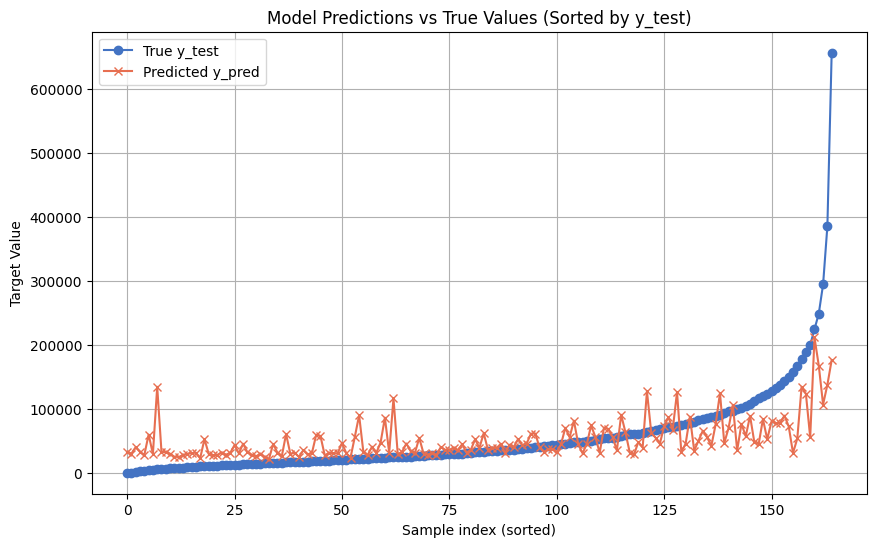

In [102]:
def test_model(X_test, y_test):
    model = trained_model
    
    # Move data to device
    X_test_device = { key: X_test[key].to(device) for key in X_test }
    y_test_device = y_test.to(device)

    # Forward pass
    with torch.no_grad():
        y_pred = model(X_test_device).squeeze()

    y_test_flat = y_test_device.clone().squeeze()

    # Compute losses
    l1loss  = torch.nn.L1Loss()
    mseloss = torch.nn.MSELoss()

    l1  = l1loss(y_pred, y_test_flat)
    mse = mseloss(y_pred, y_test_flat)

    # Compute R^2 (on CPU NumPy)
    y_true_np = y_test_flat.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    r2 = r2_score(y_true_np, y_pred_np)
    
    rate = 0.0098
    
    # Print metrics
    print(f"{'Metric':<15} {'Loss (Rupee)':>15} {'Conversion Rate':>20} {'Loss (CHF)':>15}")
    print(f"{'-'*65}")
    print(f"{'L1 Loss MAE':<15} {l1:>15.4f} {'0.0098':>20} {(rate * l1):>15.4f}")
    print(f"{'MSE Loss':<15} {mse:>15.4f} {'0.0098':>20} {(rate * mse):>15.4f}")
    print(f"{'R^2 Score':<15} {r2:>15.4f}")

    sorted_indices = torch.argsort(y_test)
    y_test_sorted = y_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    step = 50

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_sorted.cpu().numpy()[::step], label='True y_test', marker='o', color=colors[0])
    plt.plot(y_pred_sorted.cpu().numpy()[::step], label='Predicted y_pred', marker='x', color=colors[4])
    plt.title('Model Predictions vs True Values (Sorted by y_test)')
    plt.xlabel('Sample index (sorted)')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    
    # Save the figure
    plt.savefig("plots/Predictions_Vs_TrueValues.png", dpi=300, bbox_inches='tight')
    
    plt.show()


test_model(X_test, y_test)

  0%|          | 0/1643 [00:00<?, ?it/s]

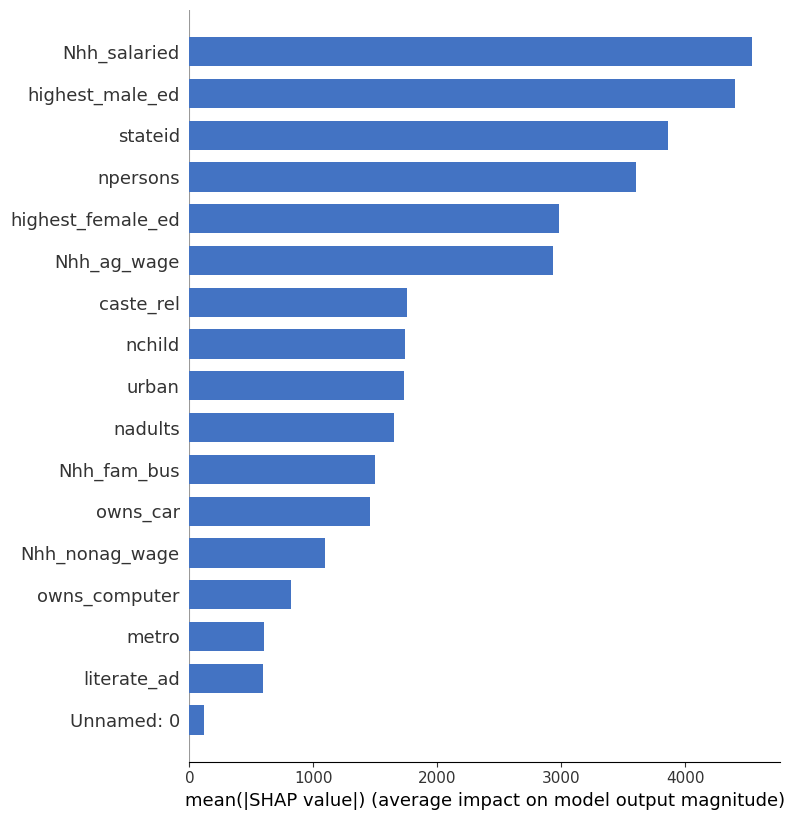

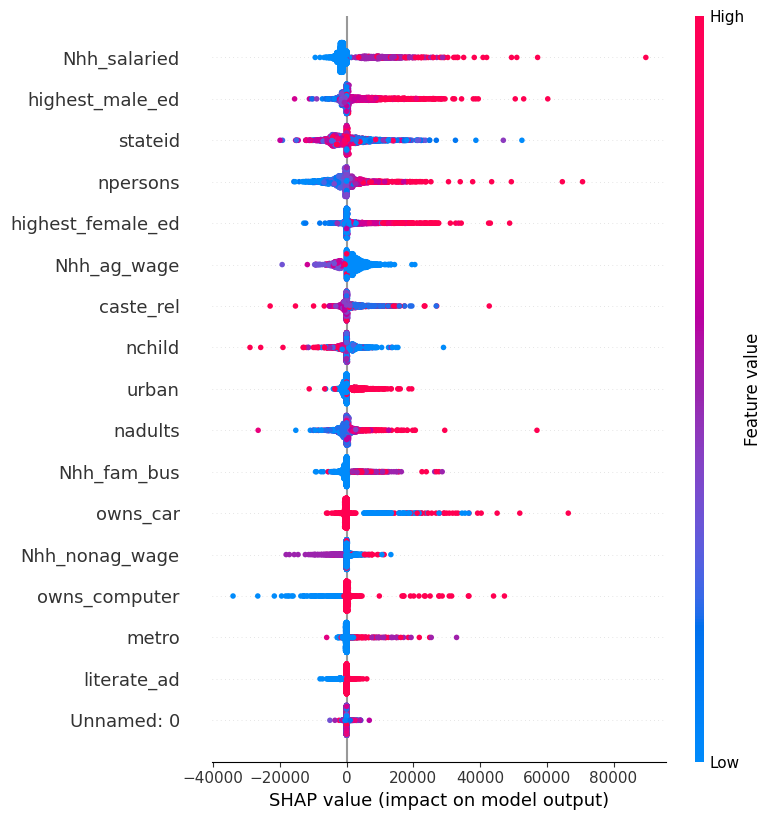

In [128]:
# SHAP - KernelExplainer
# 1. Helper to stack your dict inputs into [N, D]
def dict_to_tensor(X_dict):
    return torch.stack([X_dict[col] for col in X_dict], dim=1)

# 2. Build full tensors
X_train_tensor = dict_to_tensor(X_train)    # [N_train, D]
X_test_tensor  = dict_to_tensor(X_test)     # [N_test,  D]

# 3. Move to CPU & raw NumPy
background_full = X_train_tensor[:200].cpu().numpy()
test_array_full = X_test_tensor.cpu().numpy()

# 4. Summarize background with k-means for speed
K_bg = 30
background = shap.kmeans(background_full, K_bg).data

# 5. Subsample 10% of test set to explain
pct = 0.2
N_test = test_array_full.shape[0]
K_test = max(1, int(N_test * pct))
idx_test = np.random.choice(N_test, K_test, replace=False)
test_array = test_array_full[idx_test]

# 6. Your predict function (unchanged)
def predict_fn(np_array: np.ndarray) -> np.ndarray:
    batch = torch.tensor(np_array, dtype=torch.long, device=device)
    x_dict = {
        name: batch[:, i]
        for i, name in enumerate(X_train.keys())
    }
    with torch.no_grad():
        preds = trained_model(x_dict)
    return preds.cpu().numpy()

# 7. Create the KernelExplainer on the small background
explainer = shap.KernelExplainer(predict_fn, background)

# 8. Compute SHAP values on the test subset with fewer samples
shap_values = explainer.shap_values(test_array, nsamples=100)

# 9. Feature names
feature_names = list(X_train.keys())

# 10. Global summary plot (bar + beeswarm)
shap.summary_plot(shap_values, test_array, feature_names=feature_names, plot_type="bar", color=colors[0])
shap.summary_plot(shap_values, test_array, feature_names=feature_names)

In [104]:
# Also clean state names in IHDS to match shapefile
state_lookup = {
    1:  'jammu & kashmir',
    2:  'himachal pradesh',
    3:  'punjab',
    4:  'chandigarh',
    5:  'uttarakhand',
    6:  'haryana',
    7:  'nct of delhi',  # corrected from 'delhi'
    8:  'rajasthan',
    9:  'uttar pradesh',
    10: 'bihar',
    11: 'sikkim',
    12: 'arunanchal pradesh',  # corrected typo 'arunachal'
    13: 'nagaland',
    14: 'manipur',
    15: 'mizoram',
    16: 'tripura',
    17: 'meghalaya',
    18: 'assam',
    19: 'west bengal',
    20: 'jharkhand',
    21: 'odisha',  # corrected from 'orissa'
    22: 'chhattisgarh',
    23: 'madhya pradesh',
    24: 'gujarat',
    25: 'daman & diu',
    26: 'dadara & nagar havelli',  # corrected spelling
    27: 'maharashtra',
    28: 'andhra pradesh',
    29: 'karnataka',
    30: 'goa',
    31: 'lakshadweep',
    32: 'kerala',
    33: 'tamil nadu',
    34: 'puducherry'  # corrected from 'pondicherry'
}

# Load the district shapefile
districts = gpd.read_file("India_districts/2011_Dist.shp")
districts['ST_NM_clean'] = districts['ST_NM'].str.lower().str.strip()

MSE = 3940377088.000, MAE = 29397.441, R2 = 0.309
Quartile           Loss (Rupee)      Conversion Rate      Loss (CHF)
----------------------------------------------------------------------
1 – Lowest           22659.9277               0.0098        222.0673
2 – Low              15028.4355               0.0098        147.2787
3 – High             15685.5703               0.0098        153.7186
4 – Highest          64234.0625               0.0098        629.4938


/var/folders/nk/x80qqs8j2d3d7n0h5xw1d8c00000gn/T/ipykernel_14160/2536786239.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_per_quartile = df.groupby('quartile').apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))
/var/folders/nk/x80qqs8j2d3d7n0h5xw1d8c00000gn/T/ipykernel_14160/2536786239.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_per_quartile = df.groupby('quartile').apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))
/var/folders/nk/x80qqs8j2d3d7n0h5xw1d8c00000g

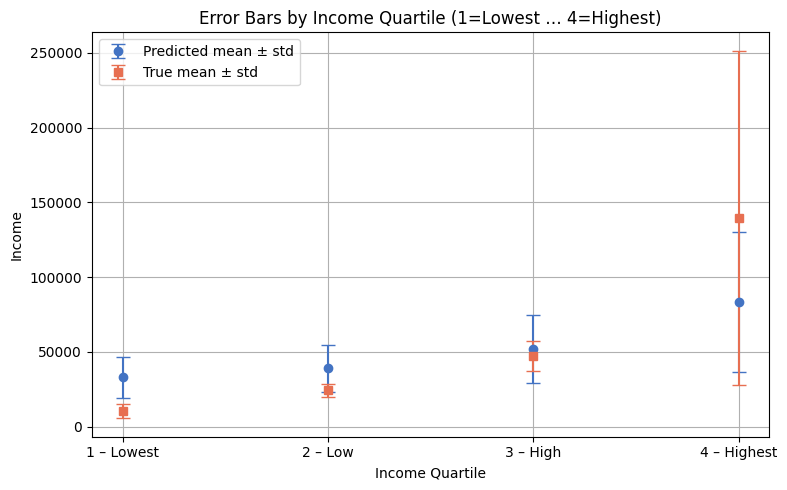


Feature correlations (Pearson r, p-value):
  Unnamed: 0: r=-0.06, p=0.000
  stateid: r=-0.07, p=0.000
  highest_male_ed: r=0.39, p=0.000
  highest_female_ed: r=0.39, p=0.000
  literate_ad: r=0.20, p=0.000
  Nhh_salaried: r=0.30, p=0.000
  Nhh_ag_wage: r=-0.18, p=0.000
  Nhh_nonag_wage: r=-0.11, p=0.000
  Nhh_fam_bus: r=0.14, p=0.000
  owns_car: r=0.10, p=0.000
  owns_computer: r=0.06, p=0.000
  npersons: r=0.17, p=0.000
  nchild: r=-0.01, p=0.455
  nadults: r=0.29, p=0.000
  urban: r=0.22, p=0.000
  metro: r=0.12, p=0.000
  caste_rel: r=-0.08, p=0.000

Baseline MAE: 29397.441
  Unnamed: 0: ΔMSE = 0.0000
  stateid: ΔMSE = 1324.5020
  highest_male_ed: ΔMSE = 1659.7305
  highest_female_ed: ΔMSE = 899.4844
  literate_ad: ΔMSE = 199.6113
  Nhh_salaried: ΔMSE = 2536.4648
  Nhh_ag_wage: ΔMSE = 810.4199
  Nhh_nonag_wage: ΔMSE = 600.2598
  Nhh_fam_bus: ΔMSE = 582.0195
  owns_car: ΔMSE = 997.8145
  owns_computer: ΔMSE = 446.6035
  npersons: ΔMSE = 1041.5625
  nchild: ΔMSE = 171.7988
  nadults: 

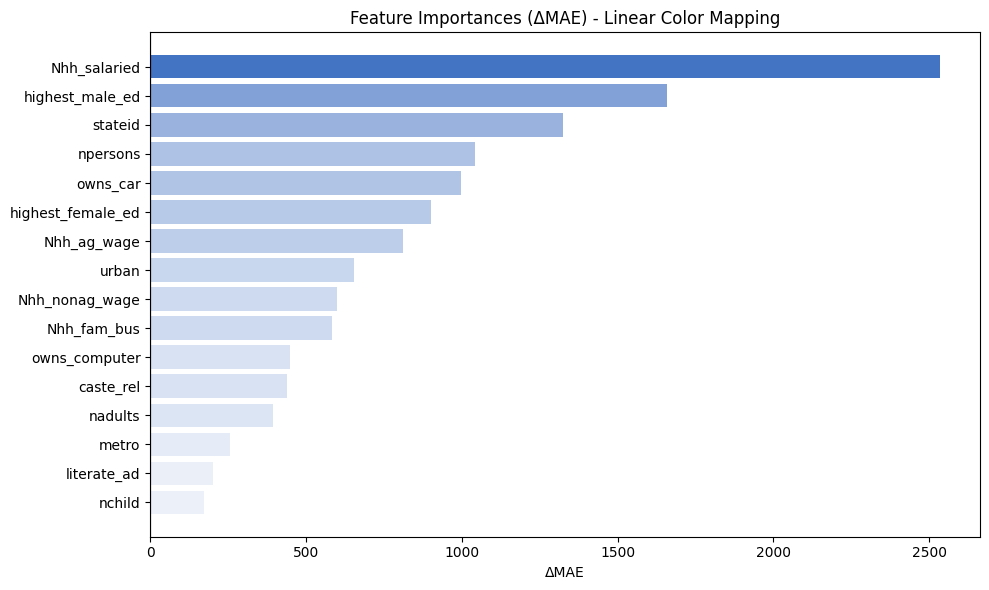

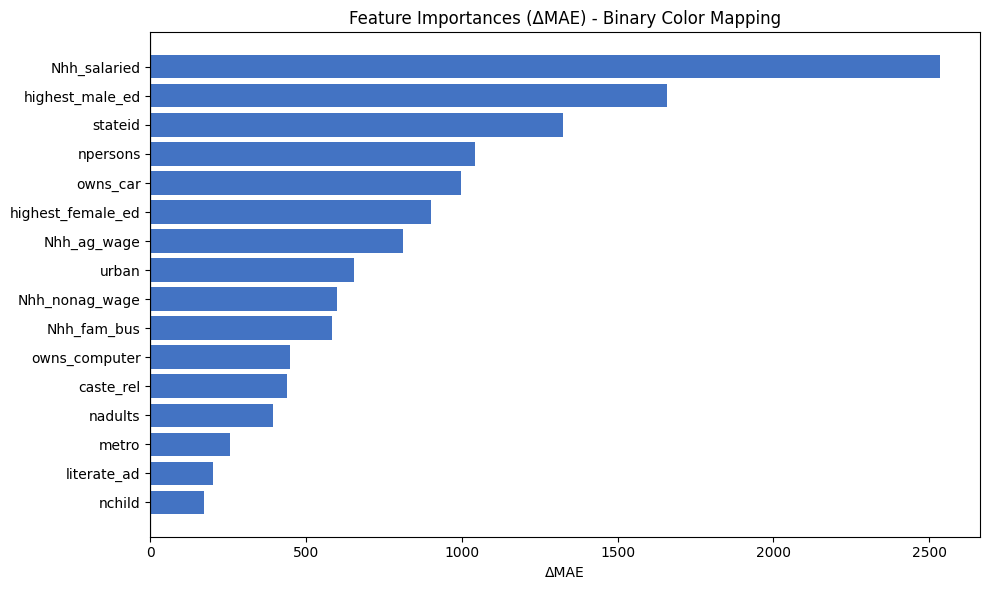


5. Noise robustness    MSE_noisy=3940377088.0000

Train vs Test (you need train R2); Test R2 = 0.309

8. Fairness
Region 1: MSE = 6630474752.000
Region 2: MSE = 5052344832.000
Region 3: MSE = 4960945664.000
Region 4: MSE = 4355666432.000
Region 5: MSE = 1482429568.000
Region 6: MSE = 4570683904.000
Region 7: MSE = 1718440448.000
Region 8: MSE = 4098513408.000
Region 9: MSE = 1624254720.000
Region 10: MSE = 1113950976.000
Region 11: MSE = 1044180032.000
Region 12: MSE = 1991718144.000
Region 13: MSE = 1871656960.000
Region 14: MSE = 46449602560.000
Region 15: MSE = 6106033152.000
Region 16: MSE = 652361152.000
Region 17: MSE = 3960098560.000
Region 18: MSE = 10480962560.000
Region 19: MSE = 2103131904.000
Region 20: MSE = 4532967424.000
Region 21: MSE = 844438720.000
Region 22: MSE = 533979744.000
Region 23: MSE = 1527249792.000
Region 24: MSE = 7780442624.000
Region 25: MSE = 10046260224.000
Region 26: MSE = 3374360320.000
Region 27: MSE = 3801593856.000
Region 28: MSE = 2984489984.00

/var/folders/nk/x80qqs8j2d3d7n0h5xw1d8c00000gn/T/ipykernel_14160/2536786239.py:219: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda sub: mean_squared_error(sub['y_true'], sub['y_pred']))


533979744.0 61170200576.0


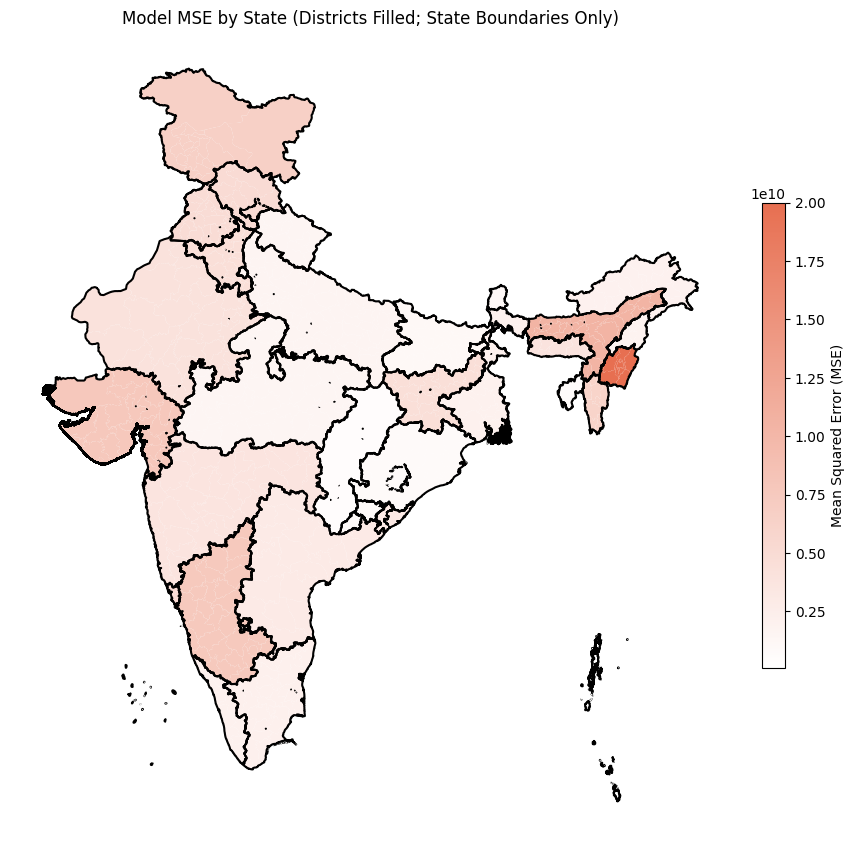


10. Overview


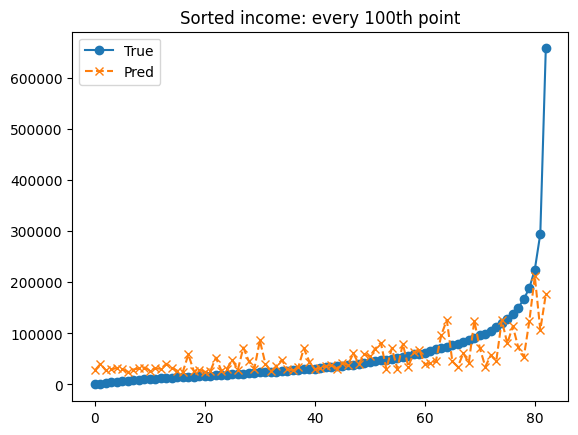

In [116]:
def analysis(X_test, y_test):
    model = trained_model
    model.to(device).eval()

    # --- 0. Initialization ---
    X_test_dev = {k: v.to(device) for k, v in X_test.items()}
    y_test_dev = y_test.to(device)
    
    with torch.no_grad():
        y_pred_dev = model(X_test_dev).squeeze()
    
    y_test_np = y_test_dev.cpu().numpy().ravel()
    y_pred_np = y_pred_dev.cpu().numpy().ravel()
    
    df = pd.DataFrame({k: X_test[k].cpu().numpy().ravel() for k in X_test})
    df['y_true'] = y_test_np
    df['y_pred'] = y_pred_np
    
    # --- 1. Basic Metrics ---
    mse = mean_squared_error(y_test_np, y_pred_np)
    mae = mean_absolute_error(y_test_np, y_pred_np)
    r2  = r2_score(y_test_np, y_pred_np)
    print(f"MSE = {mse:.3f}, MAE = {mae:.3f}, R2 = {r2:.3f}")
    
    # --- 2. Error Bars by Ordered Quartile of y_true ----------------------------------------------------------------------------
    quartile_labels = ["1 – Lowest", "2 – Low", "3 – High", "4 – Highest"]
    df['quartile'] = pd.qcut(df['y_true'], 4, labels=quartile_labels)

    # Print out error
    conversion_rate = 0.0098
    
    # Assign quartile labels
    quartile_labels = ["1 – Lowest", "2 – Low", "3 – High", "4 – Highest"]
    df['quartile'] = pd.qcut(df['y_true'], 4, labels=quartile_labels)
    
    # Compute MAE per quartile
    mae_per_quartile = df.groupby('quartile').apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))
    
    # Print header
    print(f"{'Quartile':<15} {'Loss (Rupee)':>15} {'Conversion Rate':>20} {'Loss (CHF)':>15}")
    print(f"{'-'*70}")
    
    # Print MAE for each quartile
    for quartile, l1 in mae_per_quartile.items():
        print(f"{str(quartile):<15} {l1:>15.4f} {conversion_rate:>20} {(conversion_rate * l1):>15.4f}")
    
    # aggregate means and stds per quartile
    grouped = df.groupby('quartile').agg({
        'y_true': ['mean', 'std'],
        'y_pred': ['mean', 'std']
    })
    # flatten column names
    grouped.columns = ['_'.join(col) for col in grouped.columns]
    
    plt.figure(figsize=(8, 5))

    x = np.arange(len(quartile_labels))
    offset = 0.00  # Controls how far apart the bars are
    
    # Plot predicted values slightly to the left
    plt.errorbar(
        x - offset,
        grouped['y_pred_mean'],
        yerr=grouped['y_pred_std'],
        fmt='o', label='Predicted mean ± std',
        color=colors[0],
        capsize=5
    )
    
    # Plot true values slightly to the right
    plt.errorbar(
        x + offset,
        grouped['y_true_mean'],
        yerr=grouped['y_true_std'],
        fmt='s', label='True mean ± std',
        color=colors[4],
        capsize=5
    )
    
    plt.xticks(x, quartile_labels)
    plt.xlabel("Income Quartile")
    plt.ylabel("Income")
    plt.title("Error Bars by Income Quartile (1=Lowest … 4=Highest)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
        
    # Save the figure 
    plt.savefig("plots/Predictions_Vs_TrueValues_Based_on_Quartile.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # --- 3. Statistical Significance of Feature Correlations ---------------------------------------------------------------------------------------------------------------
    print("\nFeature correlations (Pearson r, p-value):")
    for feat in X_test:
        r, p = pearsonr(df[feat], df['y_true'])
        print(f"  {feat}: r={r:.2f}, p={p:.3f}")
    
    # --- 4. Permutation-Importance (Sensitivity Analysis) ---
    # baseline_mse = mean_squared_error(y_test_np, y_pred_np)
    baseline_mse = mae
    print(f"\nBaseline MAE: {baseline_mse:.3f}")
    
    import copy
    feature_importances = {}
    
    # For each feature, permute its values and recompute MSE
    for i, feat in enumerate(X_test):
        X_perm = copy.deepcopy(df)  # make a fresh copy
        # shuffle only this column
        X_perm[feat] = np.random.permutation(X_perm[feat].values)
        
        # build input dict for model
        X_perm_dict = {
            k: torch.from_numpy(X_perm[k].values).long().to(device)
            for k in X_test
        }
        with torch.no_grad():
            y_pred_perm = model(X_perm_dict).squeeze().cpu().numpy()
        
        mse_perm = mean_absolute_error(df['y_true'], y_pred_perm)
        importance = mse_perm - baseline_mse
        feature_importances[feat] = importance
        print(f"  {feat}: ΔMSE = {importance:.4f}")
        
    print("\nFeatures sorted by importance (ΔMSE):")
    for feat, imp in sorted(feature_importances.items(), key=lambda x: -x[1]):
        print(f"  {feat}: ΔMSE = {imp:.4f}")

    # added
    # Sort feature importances and prepare data
    
    sorted_items = sorted(feature_importances.items(), key=lambda x: x[1])
    print(sorted_items)
    print("poped value: ", sorted_items.pop(0))
    features, importances = zip(*sorted_items)
    
    # Create color map
    min_val, max_val = min(importances), max(importances)
    mid_val = -100
    min_val = -1000
    
    # Color gradient: negative = #E76F51, zero = #FFFFFF, positive = #4373C3
    cmap_gradient = mcolors.LinearSegmentedColormap.from_list(
        'custom_gradient', ["#E76F51", "#FFFFFF", "#4373C3"]
    )
    norm = mcolors.TwoSlopeNorm(vmin=min_val, vcenter=mid_val, vmax=max_val)
    colors_gradient = [cmap_gradient(norm(val)) for val in importances]
    
    # Binary color map: red if < 0, blue if > 0, white if 0
    colors_binary = ['#E76F51' if val < 0 else '#4373C3' if val > 0 else '#FFFFFF' for val in importances]

    # Linear color map bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances, color=colors_gradient)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.title('Feature Importances (ΔMAE) - Linear Color Mapping')
    plt.xlabel('ΔMAE')
    plt.tight_layout()
    plt.savefig("plots/feature_importances_linear_colormap.png", dpi=300)
    
    # Binary color map bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances, color=colors_binary)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.title('Feature Importances (ΔMAE) - Binary Color Mapping')
    plt.xlabel('ΔMAE')
    plt.tight_layout()
    plt.savefig("plots/feature_importances_binary_colormap.png", dpi=300)
    
    plt.show()
        
    # 5. Noise robustness (continuous only) ----------------------------------------------------------------------------------
    # Identify which columns are continuous vs categorical
    cont_feats = [k for k,v in X_test.items() if v.dtype in (torch.float32, torch.float64)]
    cat_feats  = [k for k in X_test if k not in cont_feats]
    noise_lvl  = 0.05 * (df['y_true'].max() - df['y_true'].min())
    dfn = df.copy()
    for feat in cont_feats:
        dfn[feat] += np.random.normal(0, noise_lvl, size=len(df))
    # build X_noise dict
    Xn = {}
    for k in cat_feats:
        # keep original integer codes
        Xn[k] = X_test[k].to(device)
    for k in cont_feats:
        arr = dfn[k].values
        Xn[k] = torch.from_numpy(arr).float().to(device)
    with torch.no_grad():
        y_no = model(Xn).cpu().numpy().ravel()
    mse_no = mean_squared_error(df['y_true'], y_no)
    print(f"\n5. Noise robustness    MSE_noisy={mse_no:.4f}")

    
    # --- 6. Overfitting Check ---
    # (Here we just note R2_test = r2)
    print(f"\nTrain vs Test (you need train R2); Test R2 = {r2:.3f}")
    
    # --- 8. Fairness / Bias Check (example by a group column 'region') ---
    print(f"\n8. Fairness")
    if 'stateid' in df:
        for region, sub in df.groupby('stateid'):
            e = mean_squared_error(sub['y_true'], sub['y_pred'])
            print(f"Region {region}: MSE = {e:.3f}")

    print(f"\n Fairness continued with Religion")
    if 'caste_rel' in df:
        for caste, sub in df.groupby('caste_rel'):
            e = mean_squared_error(sub['y_true'], sub['y_pred'])
            print(f"Caste/ Religion {caste}: MSE = {e:.3f}")

    # plot heatmap ------------------------------------------------------------------------------------------------------------------
    # --- 1. Map to clean state names ---
    df['state_name'] = df['stateid'].map(state_lookup).str.lower().str.strip()
    
    # --- 2. Compute per-state MSE ---
    mse_df = (
        df[['state_name', 'y_true', 'y_pred']]
        .groupby('state_name', observed=True)
        .apply(lambda sub: mean_squared_error(sub['y_true'], sub['y_pred']))
        .reset_index(name='MSE')
    )
    
    # --- 3. Merge MSE into districts GeoDataFrame ---
    merged = districts.merge(
        mse_df,
        left_on='ST_NM_clean',
        right_on='state_name',
        how='left'
    )
    
    # --- 4. Subset and dissolve to get state boundaries with average MSE ---
    merged_sub = merged[['ST_NM_clean', 'geometry', 'MSE']]
    gdf_states = merged_sub.dissolve(
        by='ST_NM_clean',
        aggfunc={'MSE': 'mean'}
    ).reset_index()
    
    # --- 5. Set custom colormap ---
    print(merged_sub['MSE'].min(), merged_sub['MSE'].max())
    vmin = 1e8
    vmax = 2e10
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_cmap',
        ["#FFFFFF", colors[4]],  # [mid, vmin, vmax]
        N=256
    )
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Required for colorbar
    
    # --- 6. Plot map with colorbar ---
    fig, ax = plt.subplots(1, 1, figsize=(10, 12))
    
    # Fill districts by MSE value
    merged.plot(
        column='MSE',
        cmap=cmap,
        norm=norm,
        linewidth=0,
        edgecolor=None,
        legend=False,
        ax=ax
    )
    
    # Overlay state boundaries
    gdf_states.boundary.plot(
        ax=ax,
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Mean Squared Error (MSE)', rotation=90)
    
    # Title & clean-up
    ax.set_axis_off()
    ax.set_title('Model MSE by State (Districts Filled; State Boundaries Only)')
    
    # --- 7. Save plot ---
    plt.savefig("plots/state_mse_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()    
    # ----------------------------------
    
    # --- 9. Subjective / Sentiment Features ---
    # If you have a column 'sentiment_score', check its correlation above.
    
    # --- 10. Plot every 100th point in sorted order ---
    print(f"\n10. Overview")
    idx = np.argsort(df['y_true'].values)
    plt.plot(df['y_true'].values[idx][::100], marker='o', linestyle='-', label='True')
    plt.plot(df['y_pred'].values[idx][::100], marker='x', linestyle='--', label='Pred')
    plt.legend(); plt.title("Sorted income: every 100th point"); plt.show()
        


analysis(X_test, y_test)

/var/folders/nk/x80qqs8j2d3d7n0h5xw1d8c00000gn/T/ipykernel_14160/2593203437.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))


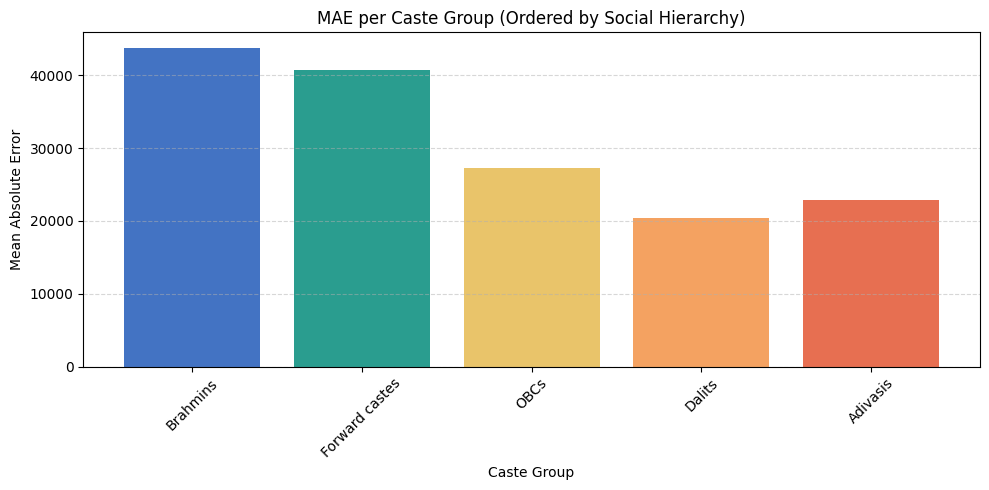

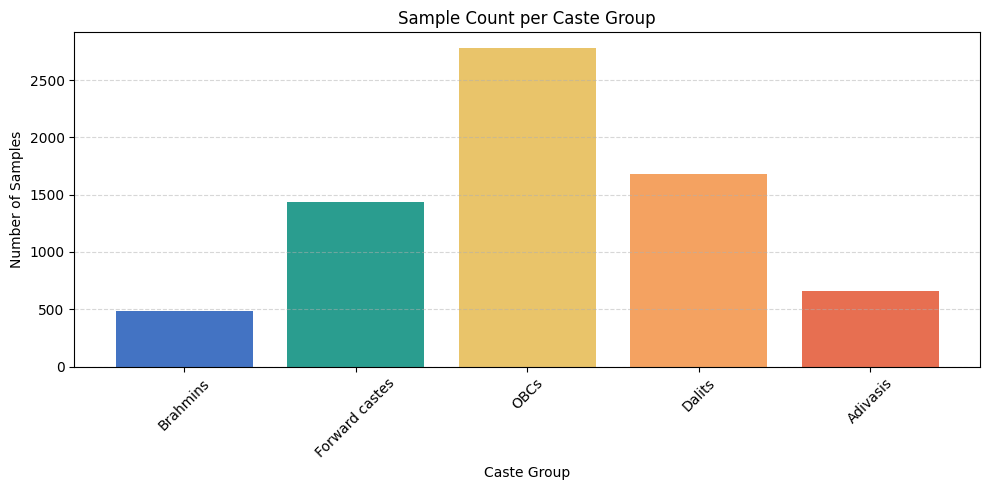

/var/folders/nk/x80qqs8j2d3d7n0h5xw1d8c00000gn/T/ipykernel_14160/2593203437.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))


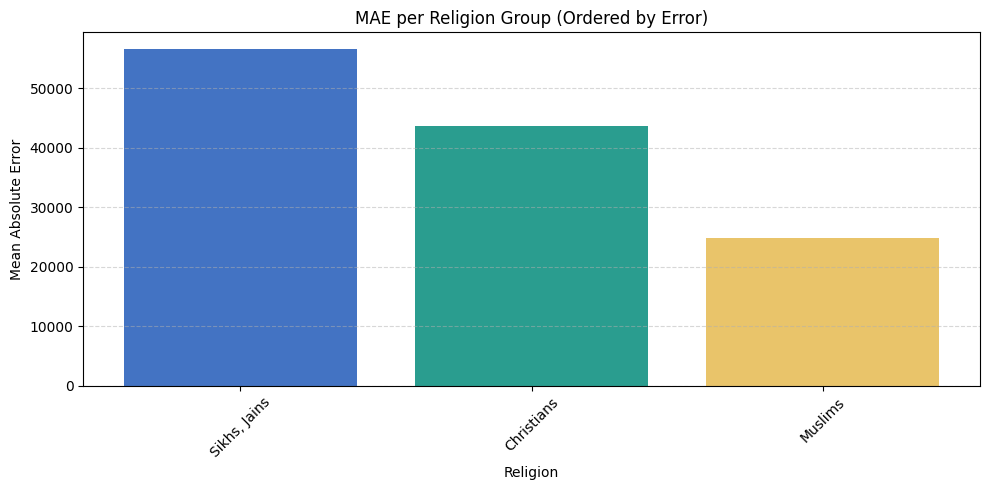

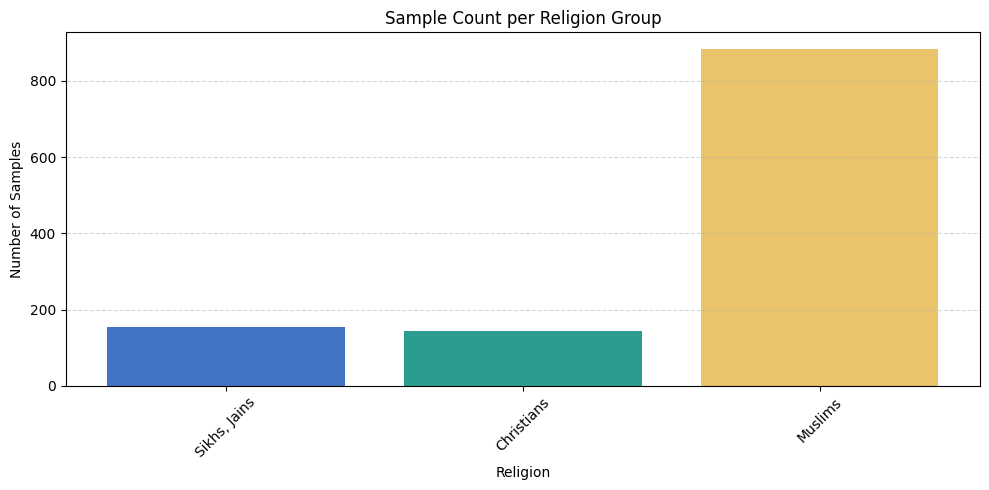

In [127]:

def analysis2(X_test, y_test):
    model = trained_model
    model.to(device).eval()

    # --- 0. Initialization ---
    X_test_dev = {k: v.to(device) for k, v in X_test.items()}
    y_test_dev = y_test.to(device)
    
    with torch.no_grad():
        y_pred_dev = model(X_test_dev).squeeze()
    
    y_test_np = y_test_dev.cpu().numpy().ravel()
    y_pred_np = y_pred_dev.cpu().numpy().ravel()

    # --- 1. Build DataFrame ---
    df = pd.DataFrame({k: X_test[k].cpu().numpy().ravel() for k in X_test})
    df['y_true'] = y_test_np
    df['y_pred'] = y_pred_np

    # --- 2. Define caste & religion labels ---
    caste_labels = {
        1: "Brahmins",
        2: "Forward castes",
        3: "OBCs",
        4: "Dalits",
        5: "Adivasis",
        6: "Muslims",
        7: "Sikhs, Jains",
        8: "Christians"
    }
    caste_order = {
        1: "Brahmins",
        2: "Forward castes",
        3: "OBCs",
        4: "Dalits",
        5: "Adivasis",
    }
    df['caste_label'] = df['caste_rel'].map(caste_order)

    religion_labels = {
        6: "Muslims",
        7: "Sikhs, Jains",
        8: "Christians"
    }
    df['religion_label'] = df['caste_rel'].map(religion_labels)

    ### --- CASTE ANALYSIS ---
    caste_hierarchy = [
        "Brahmins", "Forward castes", "OBCs", "Dalits", "Adivasis", "Muslims", "Sikhs, Jains", "Christians"
    ]
    caste_mae_df = (
        df.groupby('caste_label')
          .apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))
          .reset_index(name='MAE')
    )
    caste_count_df = df['caste_label'].value_counts().rename_axis('caste_label').reset_index(name='count')
    caste_df = pd.merge(caste_mae_df, caste_count_df, on='caste_label')

    caste_df['caste_label'] = pd.Categorical(caste_df['caste_label'], categories=caste_hierarchy, ordered=True)
    caste_df = caste_df.sort_values('caste_label').reset_index(drop=True)

    colors_sub = [colors[i % 5] for i in range(len(caste_df))]

    # Plot MAE per caste
    plt.figure(figsize=(10, 5))
    plt.bar(caste_df['caste_label'], caste_df['MAE'], color=colors_sub)
    plt.title('MAE per Caste Group (Ordered by Social Hierarchy)')
    plt.xlabel('Caste Group')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("plots/bias_caste_label_MAE.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot sample count per caste
    plt.figure(figsize=(10, 5))
    plt.bar(caste_df['caste_label'], caste_df['count'], color=colors_sub)
    plt.title('Sample Count per Caste Group')
    plt.xlabel('Caste Group')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("plots/bias_caste_label_number.png", dpi=300, bbox_inches='tight')
    plt.show()

    ### --- RELIGION ANALYSIS ---
    rel_mae_df = (
        df.groupby('religion_label')
          .apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))
          .reset_index(name='MAE')
    )
    rel_count_df = df['religion_label'].value_counts().rename_axis('religion_label').reset_index(name='count')
    rel_df = pd.merge(rel_mae_df, rel_count_df, on='religion_label')
    rel_df = rel_df.sort_values(by='MAE', ascending=False).reset_index(drop=True)

    colors_sub = [colors[i % 5] for i in range(len(rel_df))]

    # Plot MAE per religion
    plt.figure(figsize=(10, 5))
    plt.bar(rel_df['religion_label'], rel_df['MAE'], color=colors_sub)
    plt.title('MAE per Religion Group (Ordered by Error)')
    plt.xlabel('Religion')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("plots/bias_religion_label_MAE.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot sample count per religion
    plt.figure(figsize=(10, 5))
    plt.bar(rel_df['religion_label'], rel_df['count'], color=colors_sub)
    plt.title('Sample Count per Religion Group')
    plt.xlabel('Religion')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("plots/bias_religion_label_number.png", dpi=300, bbox_inches='tight')
    plt.show()

analysis2(X_test, y_test)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     533.0
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        22:28:36   Log-Likelihood:            -4.1610e+05
No. Observations:               32873   AIC:                         8.322e+05
Df Residuals:                   32856   BIC:                         8.324e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.103e+04   1876.09

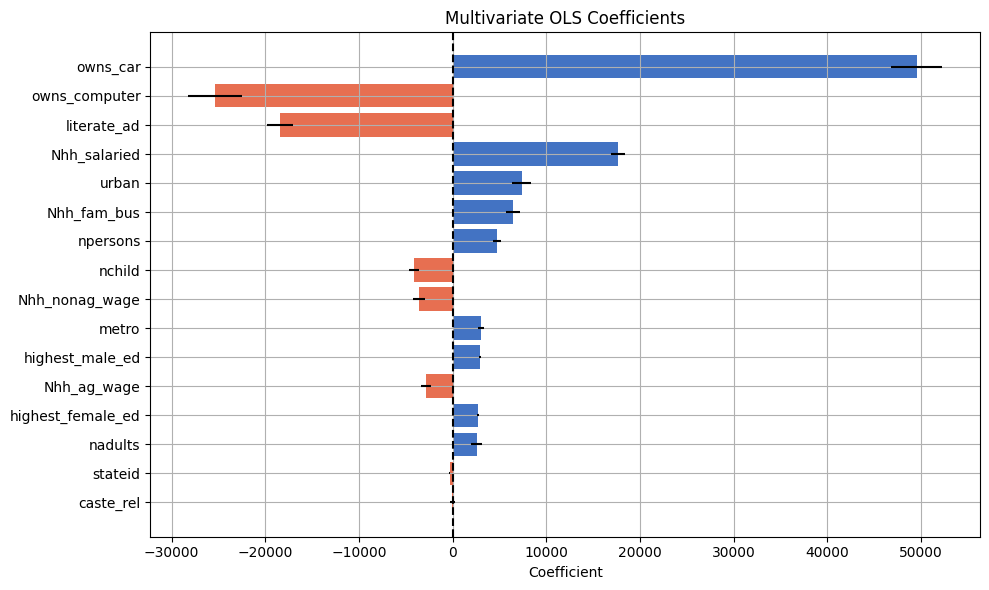

[OLS Test Residuals] Skewness: 5.633
[OLS Test Residuals] Kurtosis: 61.212
[OLS Test Residuals] Omnibus test: stat=9185.721, p=0.000e+00


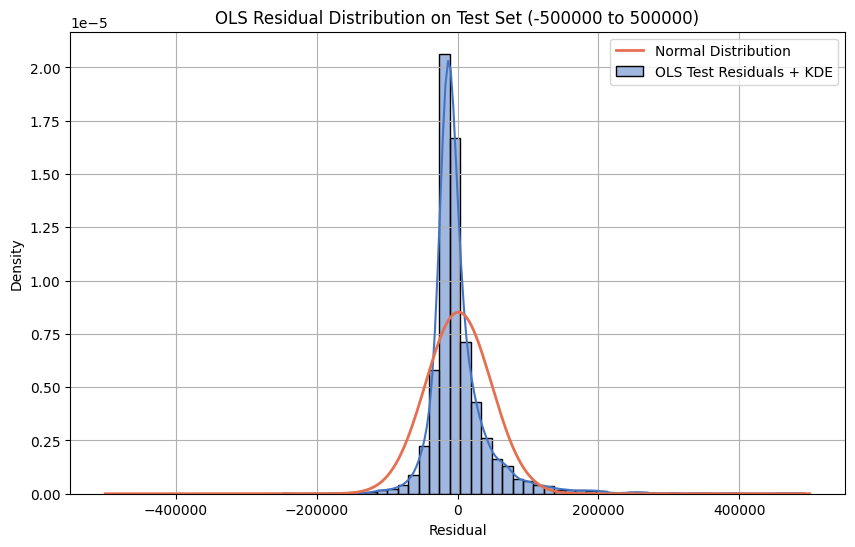

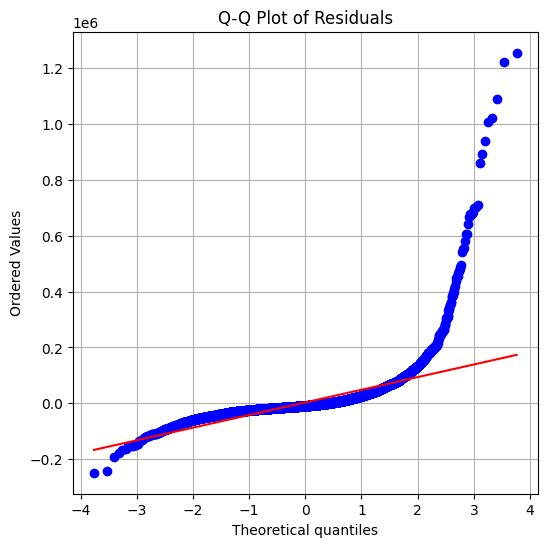

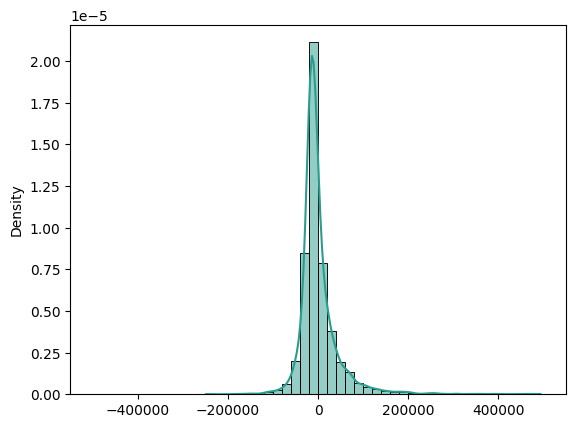

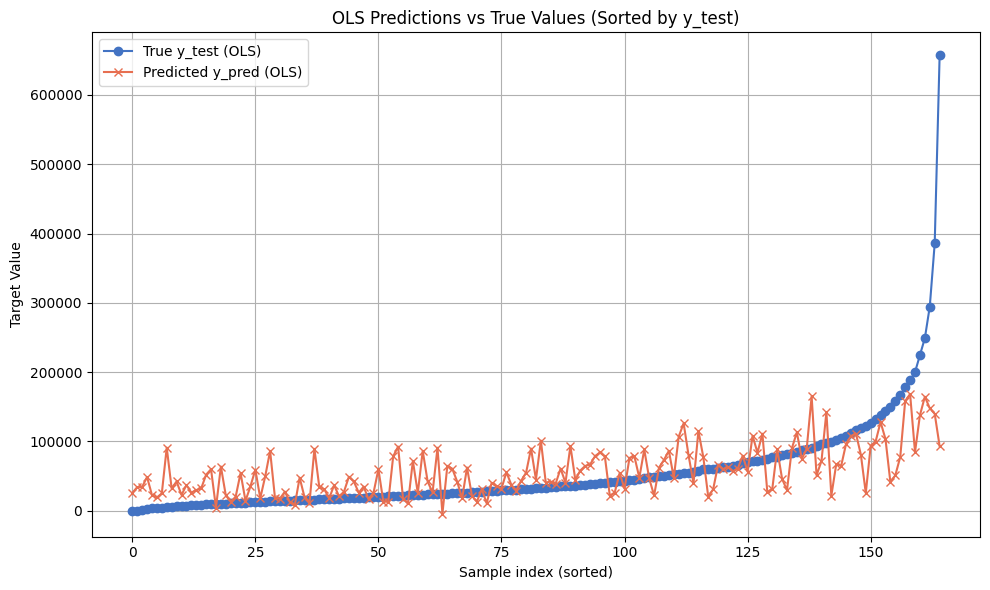

In [118]:
# Step 1: Remove 'Unnamed: 0' from feature names
feature_names = [k for k in X_train.keys() if k != 'Unnamed: 0']

# Step 2: Convert tensor dict to DataFrame (excluding 'Unnamed: 0')
def tensor_dict_to_df(tensor_dict):
    return pd.DataFrame({
        k: v.cpu().numpy()
        for k, v in tensor_dict.items()
        if k != 'Unnamed: 0'
    })

df_train = tensor_dict_to_df(X_train)
df_train['y'] = y_train.cpu().numpy()

# Step 3: Fit model
X = df_train[feature_names]  # this now works!
X = sm.add_constant(X)
y = df_train['y']

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

# --- Step 3: Plot Coefficients with Colors ---
coefs = model.params[1:]          # exclude the intercept
errors = model.bse[1:]            # std errors for plotting error bars
pvals = model.pvalues[1:]         # p-values (optional: for filtering)
names = coefs.index

# Sort by absolute effect size (optional)
sorted_idx = coefs.abs().sort_values(ascending=True).index
coefs = coefs[sorted_idx]
errors = errors[sorted_idx]
# names is already aligned with coefs now

# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    coefs.index,
    coefs.values,
    xerr=errors.values,
    color=[colors[4] if c < 0 else colors[0] for c in coefs.values]
)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Coefficient')
plt.title('Multivariate OLS Coefficients')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/ols_coefficients.png", dpi=300)
plt.show()

# analysis kurtosis on test set
# --- 2. Predict on test set ---
df_test = tensor_dict_to_df(X_test)
df_test['y'] = y_test.cpu().numpy()

X_test_df = sm.add_constant(df_test[feature_names], has_constant='add')  # Important!
y_test_np = df_test['y']

y_pred_test = model.predict(X_test_df)

# --- 3. Residuals ---
residuals_ols_test = y_test_np - y_pred_test

filtered_resid = residuals_ols_test[(residuals_ols_test > -1e6) & (residuals_ols_test < 1e6)]
skewness = stats.skew(filtered_resid)
kurtosis_val = stats.kurtosis(filtered_resid, fisher=False)
omni_stat, omni_p = omni_normtest(filtered_resid)

print(f"[OLS Test Residuals] Skewness: {skewness:.3f}")
print(f"[OLS Test Residuals] Kurtosis: {kurtosis_val:.3f}")
print(f"[OLS Test Residuals] Omnibus test: stat={omni_stat:.3f}, p={omni_p:.3e}")

# plot distribution ---------------------------
bar_color = colors[0]
norm_color = colors[4]

# --- Fit normal distribution to residuals ---
mean_resid = filtered_residuals.mean()
std_resid = filtered_residuals.std()
x = np.linspace(-1e6*show, 1e6*show, 500)
normal_pdf = stats.norm.pdf(x, loc=mean_resid, scale=std_resid)

# --- Plot ---
plt.figure(figsize=(10, 6))

# Histogram with KDE
sns.histplot(filtered_residuals, bins=50, stat="density", color=bar_color, kde=True, label="OLS Test Residuals + KDE")

# Normal distribution line
plt.plot(x, normal_pdf, color=colors[4], lw=2, label="Normal Distribution")

plt.title(f"OLS Residual Distribution on Test Set ({-1e6*show:.0f} to {1e6*show:.0f})")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Q-Q plot (for normality)
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()


num_bins = 50
bin_edges = np.linspace(-1e6 * show, 1e6 * show, num_bins + 1)
sns.histplot(filtered_residuals, bins=bin_edges, stat="density", kde=True, color=colors[1], label="OLS Residuals + KDE")

# add plot
# Convert to NumPy arrays (if not already)
y_test_tensor = torch.tensor(y_test_np)
y_pred_tensor = torch.tensor(y_pred_test)

# Sort by true y values
sorted_indices = torch.argsort(y_test_tensor)
y_test_sorted = y_test_tensor[sorted_indices]
y_pred_sorted = y_pred_tensor[sorted_indices]

# Plot every Nth value for clarity
step = 50

plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted.numpy()[::step], label='True y_test (OLS)', marker='o', color=colors[0])
plt.plot(y_pred_sorted.numpy()[::step], label='Predicted y_pred (OLS)', marker='x', color=colors[4])
plt.title('OLS Predictions vs True Values (Sorted by y_test)')
plt.xlabel('Sample index (sorted)')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Skewness: 3.384
Kurtosis: 25.649
Omnibus test: stat=6251.016, p=0.000e+00


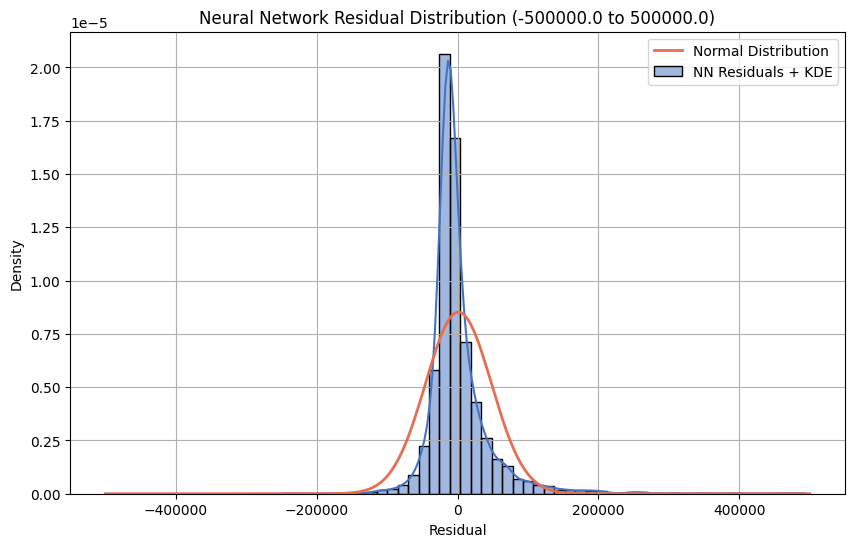

<Axes: ylabel='Density'>

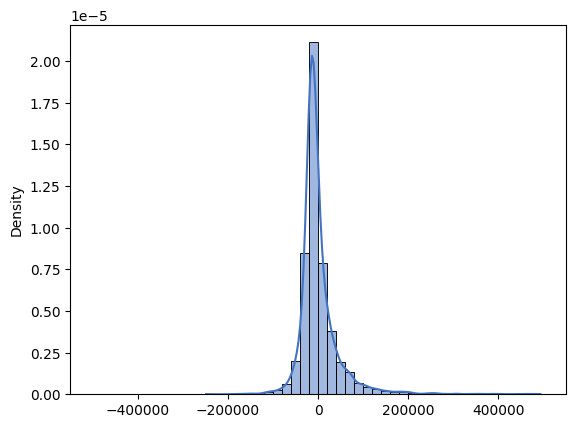

In [107]:
trained_model = trained_model.to(device)

# --- 1. Move data to device ---
X_test_device = {k: v.to(device) for k, v in X_test.items()}
y_test_device = y_test.to(device)

# --- 2. Forward pass ---
trained_model.eval()
with torch.no_grad():
    y_pred = trained_model(X_test_device).cpu().numpy()  # detach and move to CPU for NumPy

# --- 3. Residuals ---
residuals = y_test_device.cpu().numpy() - y_pred
filtered_residuals = residuals[(residuals > -1e6*show) & (residuals < 1e6*show)]

# --- 4. Stats ---
skewness = stats.skew(filtered_residuals)
kurtosis_val = stats.kurtosis(filtered_residuals, fisher=False)
omni_stat, omni_p = omni_normtest(filtered_residuals)

print(f"Skewness: {skewness:.3f}")
print(f"Kurtosis: {kurtosis_val:.3f}")
print(f"Omnibus test: stat={omni_stat:.3f}, p={omni_p:.3e}")

# --- 5. Plot ---
mean_resid = filtered_residuals.mean()
std_resid = filtered_residuals.std()
x = np.linspace(-1e6*show, 1e6*show, 500)
normal_pdf = stats.norm.pdf(x, loc=mean_resid, scale=std_resid)

plt.figure(figsize=(10, 6))

# Histogram + KDE
sns.histplot(filtered_residuals, bins=50, stat="density", kde=True, color=colors[0], label="NN Residuals + KDE")

# Normal curve
plt.plot(x, normal_pdf, color=colors[4], lw=2, label="Normal Distribution")

plt.title(f"Neural Network Residual Distribution ({show*-1e6} to {show*1e6})")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Use in both histplots
sns.histplot(filtered_residuals, bins=bin_edges, stat="density", kde=True, color=colors[0], label="NN Residuals + KDE")

In [108]:
# Local explanation for first test instance
shap.initjs()

# 2) Prepare a single-row DataFrame (or just use the NumPy row + feature_names)
instance_idx = 8
row_array = test_array[instance_idx]                       # shape (D,)
row_df    = pd.DataFrame([row_array], columns=feature_names)

# 3) Draw the force plot
shap.force_plot(
    explainer.expected_value,    # scalar or length-1 list
    shap_values[instance_idx],    # shape (D,)
    row_df                        # DataFrame with 1 row
)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[instance_idx],
        base_values=explainer.expected_value,
        data=test_array[instance_idx],
        feature_names=feature_names
    )
)

shap.summary_plot(
    shap_values,
    test_array,
    feature_names=feature_names,
    plot_type="bar"
)

shap.summary_plot(
    shap_values,
    test_array,
    feature_names=feature_names
)

shap.dependence_plot(
    "highest_male_ed",             # feature name
    shap_values,
    test_array,
    feature_names=feature_names
)

shap.dependence_plot(
    "highest_male_ed",
    shap_values,
    test_array,
    feature_names=feature_names,
    interaction_index="hhassets"
)

# mean absolute SHAP per feature
mean_abs = np.abs(shap_values).mean(axis=0)

feat_imp = pd.Series(
    mean_abs,
    index=feature_names
).sort_values(ascending=False)

print(feat_imp)

ValueError: 16 columns passed, passed data had 17 columns